In [1]:
# Importing Library 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setting Directory
train_dir = "/kaggle/input/immmaaa/images/images/train"
val_dir = "/kaggle/input/immmaaa/images/images/validation"
test_dir = "/kaggle/input/immmaaa/images/images/final test"

# Setting up Hyperparameter
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 100
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA=3

#Encoding Labels
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]

In [3]:
#Pre-processing
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   preprocessing_function=preprocess_fun
                                  )
val_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun)
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun)


#Data Generator 
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12)
                                                   
validation_generator = val_datagen.flow_from_directory(directory = val_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 26921 images belonging to 7 classes.
Found 0 images belonging to 7 classes.
Found 1900 images belonging to 7 classes.


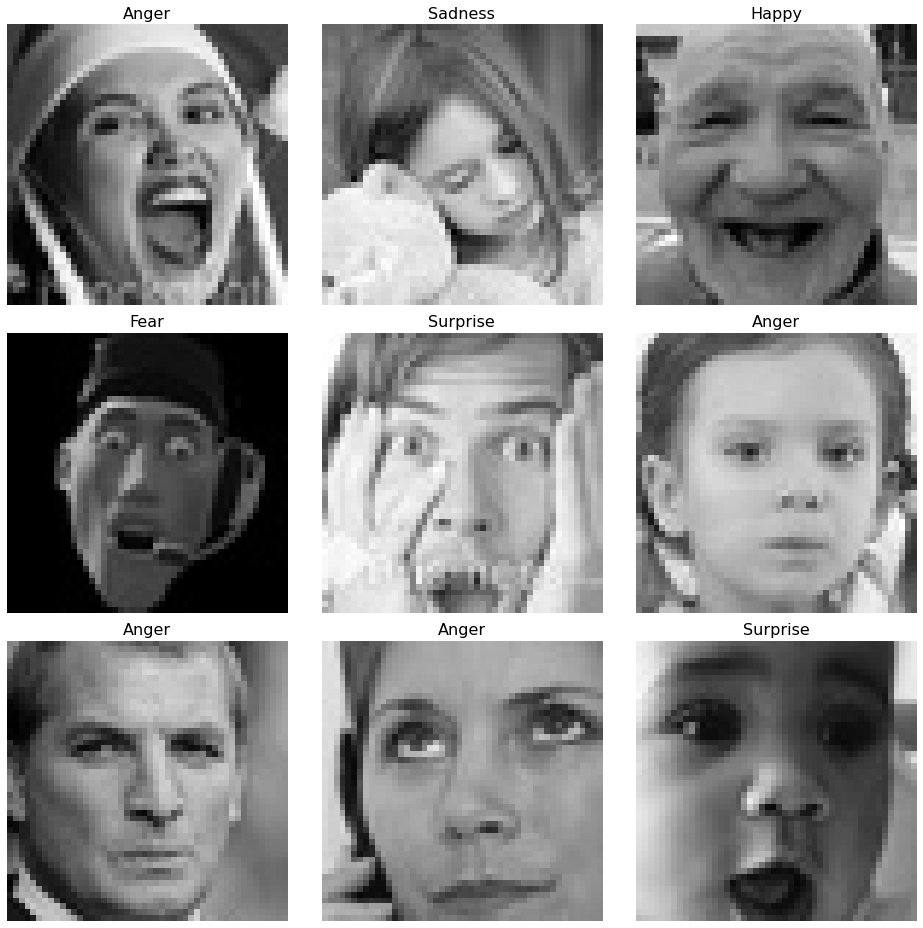

In [4]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = val_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

In [5]:
#Data distribution (count) among differnt emotions
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [6]:
#DenseNet169 
#In feature_extractor weights are set to false, so no transfer learning
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights=None)(inputs)
    
    return feature_extractor

# Addding a some layer at the top of DenseNet169 that will aid in Classification
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

## Summary of model

In [7]:
model = define_compile_model()
clear_output()

# Making all the DenseNet169 Layers trainable
model.layers[1].trainable = True

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
densenet169 (Functional)     (None, 1, 1, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               426240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0     

In [8]:
#Employing early stopping which prevents overfitting 
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
#Fitting train data over model and storing the loss history in the variable loss 
history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])
#Creating dataframe of the history
history = pd.DataFrame(history.history)

Epoch 1/100
421/421 [==============================] - 259s 569ms/step - loss: 9.2555 - accuracy: 0.2482
Epoch 2/100
421/421 [==============================] - 63s 150ms/step - loss: 3.1305 - accuracy: 0.2885
Epoch 3/100
421/421 [==============================] - 67s 158ms/step - loss: 1.9257 - accuracy: 0.3351
Epoch 4/100
421/421 [==============================] - 66s 157ms/step - loss: 1.6362 - accuracy: 0.3735
Epoch 5/100
421/421 [==============================] - 67s 158ms/step - loss: 1.5369 - accuracy: 0.3936
Epoch 6/100
421/421 [==============================] - 67s 158ms/step - loss: 1.4811 - accuracy: 0.4132
Epoch 7/100
421/421 [==============================] - 66s 158ms/step - loss: 1.4459 - accuracy: 0.4265
Epoch 8/100
421/421 [==============================] - 65s 154ms/step - loss: 1.4179 - accuracy: 0.4454
Epoch 9/100
421/421 [==============================] - 83s 198ms/step - loss: 1.3878 - accuracy: 0.4601
Epoch 10/100
421/421 [==============================] - 69s 163

In [9]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = 100 ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index=True)

Epoch 1/100
421/421 [==============================] - 75s 149ms/step - loss: 0.2852 - accuracy: 0.9335
Epoch 2/100
421/421 [==============================] - 65s 153ms/step - loss: 0.2594 - accuracy: 0.9421
Epoch 3/100
421/421 [==============================] - 62s 148ms/step - loss: 0.2375 - accuracy: 0.9479
Epoch 4/100
421/421 [==============================] - 63s 149ms/step - loss: 0.2277 - accuracy: 0.9522
Epoch 5/100
421/421 [==============================] - 64s 152ms/step - loss: 0.2182 - accuracy: 0.9546
Epoch 6/100
421/421 [==============================] - 62s 147ms/step - loss: 0.2136 - accuracy: 0.9564
Epoch 7/100
421/421 [==============================] - 64s 151ms/step - loss: 0.2062 - accuracy: 0.9583
Epoch 8/100
421/421 [==============================] - 63s 149ms/step - loss: 0.2003 - accuracy: 0.9600
Epoch 9/100
421/421 [==============================] - 64s 151ms/step - loss: 0.1990 - accuracy: 0.9597
Epoch 10/100
421/421 [==============================] - 62s 146m

<a id="vis"></a>
# <center> Visualizing Results </center> 

## Model Evaluation

In [10]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

30/30 [==============================] - 20s 599ms/step - loss: 1.7906 - accuracy: 0.6163


## Confusion Matrix

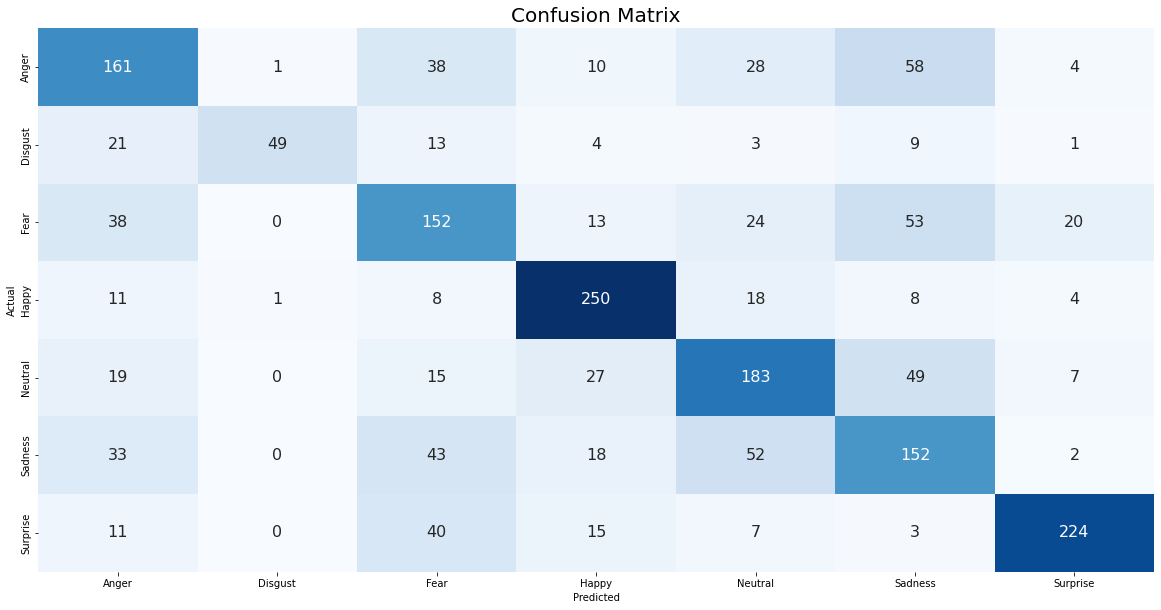

In [11]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Classification Report 

In [12]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.55      0.54      0.54       300
           1       0.96      0.49      0.65       100
           2       0.49      0.51      0.50       300
           3       0.74      0.83      0.78       300
           4       0.58      0.61      0.60       300
           5       0.46      0.51      0.48       300
           6       0.85      0.75      0.80       300

    accuracy                           0.62      1900
   macro avg       0.66      0.60      0.62      1900
weighted avg       0.63      0.62      0.62      1900



## Multiclass AUC Curve

ROC AUC score: 0.8901963065558632


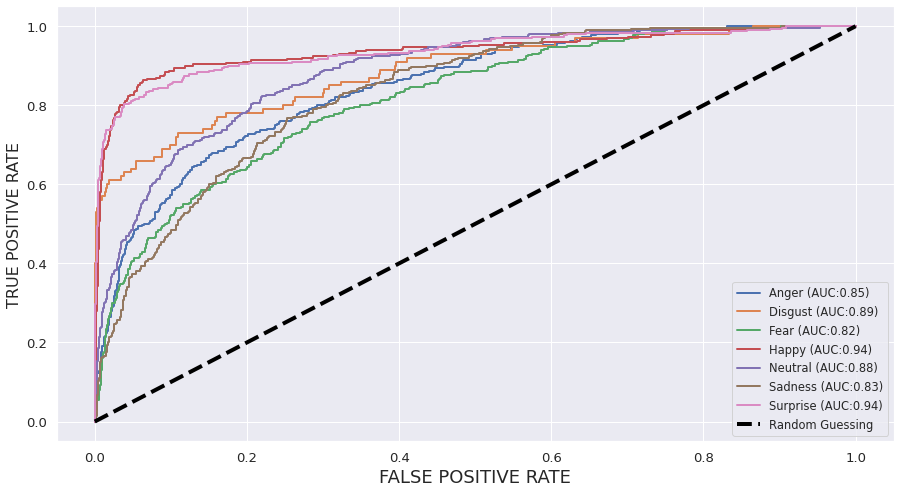

In [13]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [14]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.8768651785714285


In [15]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.8768651785714285
